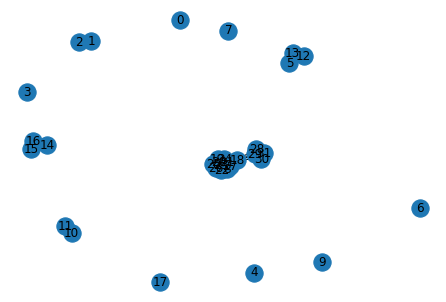

In [5]:
# libraries import
import os
import re
import json
import random
import itertools
import numpy as np
import networkx as nx
from scipy.stats import bernoulli

# fetching all the files
base_path = 'sequences/'
files = os.listdir(base_path)

# creating the Graph using networkx
G = nx.Graph()
node_index = 0

# main loop for graph construction
i = 0 # testing with just 1000 files
#for file in files:
while i < 50:
    # opening current file
    # print(files[i])
    with open(base_path + files[i]) as in_file:
        data = json.load(in_file)
    i += 1
    # isolating the comment section
    if 'comment' in data['results'][0]:
        comments_section = data['results'][0]['comment']

        # isolating the authors
        authors = []
        for comment in comments_section:
            pattern = '(_([a-zA-Z]+\.?\s?)*_)'
            results = re.findall(pattern, comment)
            if results:
                author = results[0][0].split('_')[1]
                authors.append(author)

        # adding the nodes
        for author in authors:
            if author not in nx.get_node_attributes(G, 'name').values():
                G.add_node(node_index, name = author)
                node_index += 1

        # adding the edges
        for pair in itertools.combinations(authors, 2):
            # fetching node 1
            node_1_key = list(nx.get_node_attributes(G, 'name').values()).index(pair[0])
            # fetching node 2
            node_2_key = list(nx.get_node_attributes(G, 'name').values()).index(pair[1])
            # adding the edge if it isn't already in the graph
            if (node_1_key, node_2_key) not in list(G.edges):
                G.add_edge(node_1_key, node_2_key)

nx.draw(G, with_labels = True)

[7, 9, 8, 6, 5, 4, 3, 2, 1, 0, 10]


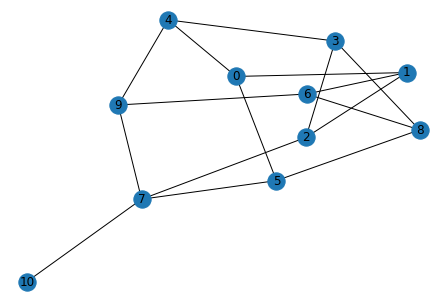

In [107]:
Gp = nx.petersen_graph()
Gp.add_node(10)
Gp.add_edge(7,10)
nx.draw(Gp, with_labels = True)
deg_ordering = get_degeneracy_ordering(Gp)
Gp_ord = deg_ordering[::-1]
print(Gp_ord)

In [7]:
# function that returns a degeneracy ordering for the graph G
def get_degeneracy_ordering(G):
    deg_ordering = []
    graph = G.copy()
    degrees = dict(graph.degree)
    for i in range(graph.number_of_nodes()):
        min_degree_node = min(degrees, key = degrees.get)
        graph.remove_node(min_degree_node)
        del degrees[min_degree_node]
        deg_ordering.append(min_degree_node)
    return deg_ordering

In [8]:
# function that given a set A returns its minimum element according to the degeneracy 
# ordering provided
def get_minimum_elem_in_deg_ord(deg_ord, A):
    if None in A:
        return A[0]
    for node in deg_ord:
        if node in A:
            return node

In [9]:
# function that returns the complementary neighborhood of a specified node set, that is all 
# the nodes that don't appear in the adjacency lists of the nodes in the set. doesn't count
# duplicates.
def get_set_complementary_neighborhood(G, A):
    compl_neighborhood = []
    for set_node in A:
        compl_neighborhood.append(list(nx.non_neighbors(G, set_node)))
    if not compl_neighborhood:
        return []
    else:
        intersection = set.intersection(*map(set, compl_neighborhood))
        return list(intersection)

In [10]:
# function that returns the neighbors of the nodes that come before the specified node
# in the degeneracy ordering
def get_neighbors_of_node_before_deg_ord(G, deg_ord, v):
    return list(set.intersection(set(G.adj[v]), set(deg_ord[:deg_ord.index(v)])))

In [11]:
# function that returns the intersection between the specified set A and the nodes that 
# appear before the specified node in the degeneracy order
def get_nodes_in_set_before_spec(deg_ord, A, v):
    return list(set.intersection(set(A), set(deg_ord[:deg_ord.index(v)])))

In [38]:
# function that returns the intersection between the specified set A and the nodes that 
# appear before the specified node or at the specified node in the degeneracy order
def get_nodes_in_set_before_equal_spec(deg_ord, A, v):
    return list(set.intersection(set(A), set(deg_ord[:deg_ord.index(v)+1])))

In [13]:
# function that returns the intersection between the specified set A and the nodes that 
# appear after the specified node in the degeneracy order
def get_nodes_in_set_after_spec(deg_ord, A, v):
    return list(set.intersection(set(A), set(deg_ord[deg_ord.index(v)+1:])))

In [14]:
# function that returns the set I<v intersected with the complementary neighborhood of v,
# that is I'v
def get_I_prime_set(G, deg_ord, IS, v):
    return list(set.intersection(set(get_nodes_in_set_before_spec(deg_ord, IS, v)), set(nx.non_neighbors(G, v))))

In [94]:
# function that returns true whether the specified IS is root in the solution digraph
def is_root(G, IS, deg_ord):
    return get_minimum_elem_in_deg_ord(deg_ord, IS) == get_parent_index(G, IS, deg_ord)

In [67]:
# function that restores the state of the parent node
def parent_state(G, IS, deg_ord):
    v = get_parent_index(G, IS, deg_ord)
    I_before_v = get_nodes_in_set_before_spec(deg_ord, IS, v)
    return complete_MIS(G, I_before_v, deg_ord), v

In [17]:
def get_next_candidate_ms(G, IS, deg_ord, v, checked):
    diff_V_IS = [node for node in G.nodes if node not in IS and node not in checked]
    diff_after_v = get_nodes_in_set_after_spec(deg_ord, diff_V_IS, v)
    return get_minimum_elem_in_deg_ord(deg_ord, diff_after_v)

In [18]:
def complete_MIS(G, IS, deg_ord):
    V_set = get_set_complementary_neighborhood(G, IS)
    while len(V_set) > 0:
        node = get_minimum_elem_in_deg_ord(deg_ord, V_set)
        IS.append(node)
        V_set.remove(node)
        for adj_node in list(G.adj[node]):
            if adj_node in V_set:
                V_set.remove(adj_node)
    return IS

In [93]:
def get_parent_index(G, IS, deg_ord):
    candidates = []
    for node in IS:
        if set(complete_MIS(G, get_nodes_in_set_before_equal_spec(deg_ord, IS, node), deg_ord)) == set(IS):
            candidates.append(node)
    return get_minimum_elem_in_deg_ord(deg_ord, candidates)

In [55]:
def build(G, A):
    ws = []
    for v in list(G.nodes):
        ws.append(len(set(G.adj[v]).intersection(set(A))))
    return ws

In [54]:
def update(G, ws, A):
    for v in list(G.nodes):
        ws[v] += len(set(G.adj[v]).intersection(set(A)))

In [68]:
def restore(G, IS, deg_ord, v):
    IS, v = parent_state(G, IS, deg_ord)
    prev = v
    I_before_v = get_nodes_in_set_before_spec(deg_ord, IS, v)
    ws = build(G, I_before_v)
    return IS, ws, v, prev

In [33]:
def child_exist_ms(G, IS, deg_ord, v):
    I_prime_v = get_I_prime_set(G, deg_ord, IS, v)
    compl_neighborhood_I_prime_v = get_set_complementary_neighborhood(G, I_prime_v + [v])
    min_elem_compl_neigh = get_minimum_elem_in_deg_ord(deg_ord, compl_neighborhood_I_prime_v)
    if not get_minimum_elem_in_deg_ord(deg_ord, [min_elem_compl_neigh, v]) == v:
        return False
    while get_set_complementary_neighborhood(G, I_prime_v):
        x = get_minimum_elem_in_deg_ord(deg_ord, get_set_complementary_neighborhood(G, I_prime_v))
        if x in get_nodes_in_set_before_spec(deg_ord, IS, v):
            I_prime_v.append(x)
        else:
            return x in IS

In [24]:
def child_exist_fast(G, IS, v, ws, deg_ord):
    neigh_before_v = get_neighbors_of_node_before_deg_ord(G, deg_ord, v)
    I_intersec_neigh_before_v = set(IS).intersection(set(neigh_before_v))
    for x in I_intersec_neigh_before_v:
        for y in G.adj[x]:
            ws[y] -= 1
    C = [node for node in list(G.nodes) if ws[node] == 0]
    I_prime_v = get_I_prime_set(G, deg_ord, IS, v)
    I_prime_v_plus_v = I_prime_v + [v]
    cn_I_prime_v_plus_v = get_set_complementary_neighborhood(G, I_prime_v_plus_v)
    min_cn_I = get_minimum_elem_in_deg_ord(deg_ord, cn_I_prime_v_plus_v)
    if not get_minimum_elem_in_deg_ord(deg_ord, [v, min_cn_I]) == v:
        return False
    while len(C) > 0:
        min_c = get_minimum_elem_in_deg_ord(deg_ord, C)
        diff_I_I_prime_v = set(IS).difference(set(I_prime_v))
        if min_c in diff_I_I_prime_v:
            C = set(C).difference(set(list(G.adj[min_c]) + [min_c]))
        else:
            update(G, ws, set(IS).intersection(set(neigh_before_v)))
            return min_c in IS

In [114]:
def wrap_iterative_spawn(G, mode):
    deg_ord = get_degeneracy_ordering(G)
    G_rev_ord = deg_ord[::-1]
    set_of_found_MIS = []
    for node in G_rev_ord:
        IS = []
        for v in G_rev_ord:
            if G.degree[v] == 0:
                IS.append(v)
        for v in IS:
            G_rev_ord.remove(v)
        IS.append(node)
        root = complete_MIS(G, IS, G_rev_ord) #[node]
        #print('ROOT:', root)
        if set(root) not in [set(MIS) for MIS in set_of_found_MIS]:
            set_of_found_MIS.append(root)
        iterative_spawn(G, root, G_rev_ord, set_of_found_MIS)
    if mode == 'all':
        return set_of_found_MIS
    else:
        return max(set_of_found_MIS, key = len)

In [112]:
def iterative_spawn(G, IS, deg_ord, set_of_found_MIS):
    v = get_parent_index(G, IS, deg_ord)
    prev = v
    ws = build(G, get_nodes_in_set_before_spec(deg_ord, IS, v))
    paths_checked = []
    while True:
        childless = True
        checked = []
        while get_next_candidate_ms(G, IS, deg_ord, v, checked) is not None:
            v = get_next_candidate_ms(G, IS, deg_ord, v, checked)
            #print('state:', IS, v, paths_checked, checked)
            update(G, ws, set(get_nodes_in_set_before_spec(deg_ord, IS, v)).difference(set(get_nodes_in_set_before_spec(deg_ord, IS, prev))))
            prev = v
            if not get_minimum_elem_in_deg_ord(deg_ord, [v, get_parent_index(G, IS, deg_ord)]) == v:
                if child_exist_fast(G, IS, v, ws, deg_ord):        
                    I_prime_v = get_I_prime_set(G, deg_ord, IS, v)             
                    if complete_MIS(G, I_prime_v + [v], deg_ord) not in paths_checked:
                        IS = complete_MIS(G, I_prime_v + [v], deg_ord)
                        if set(IS) not in [set(MIS) for MIS in set_of_found_MIS]:
                            #print('found:', IS, v)
                            set_of_found_MIS.append(IS)
                            childless = False
                            ws = build(G, get_nodes_in_set_before_spec(deg_ord, IS, v))
                            break
                        else:
                            if IS not in paths_checked:
                            #print('done:', IS)
                                paths_checked.append(IS)
                    else:
                        checked.append(v)
                else:
                    checked.append(v)
                    if v == deg_ord[-1]:
                        if IS not in paths_checked:
                            #print('done with path:', IS)
                            paths_checked.append(IS)
        if childless:
            if is_root(G, IS, deg_ord):
                return
            else:
                IS, ws, v, prev = restore(G, IS, deg_ord, v)
                #print("restoring parent:", IS)

In [95]:
is_root(Gp, set([8, 9, 2, 0]), Gp_ord)

True

In [115]:
%%time
wrap_iterative_spawn(Gp, 'all')

CPU times: user 33.5 ms, sys: 46 µs, total: 33.5 ms
Wall time: 32.2 ms


[[7, 8, 4, 1],
 [7, 6, 4],
 [6, 5, 4, 2, 10],
 [5, 6, 3, 10],
 [4, 5, 1, 10],
 [2, 6, 0, 10],
 [6, 7, 3, 0],
 [3, 7, 1],
 [0, 3, 6, 10],
 [8, 4, 2, 10],
 [8, 7, 0],
 [8, 1, 4, 10],
 [9, 8, 2, 0, 10],
 [8, 9, 1, 10],
 [5, 9, 3, 1, 10],
 [9, 5, 2, 10],
 [9, 3, 0, 10]]

In [30]:
MISGp = [[0, 2, 6],
 [0, 2, 8, 9],
 [0, 3, 6, 7],
 [0, 3, 9],
 [0, 7, 8],
 [1, 3, 5, 9],
 [1, 3, 7],
 [1, 4, 5],
 [1, 4, 7, 8],
 [1, 8, 9],
 [2, 4, 5, 6],
 [2, 4, 8],
 [2, 5, 9],
 [3, 5, 6],
 [4, 6, 7]]
[[9, 8, 2, 0],-
 [8, 7, 4, 1],-
 [7, 6, 4],-
 [6, 5, 4, 2],-
 [5, 6, 3],-
 [4, 5, 1],-
 [2, 6, 0],-
 [6, 7, 3, 0],-
 [8, 4, 2],-
 [8, 7, 0],-
 [9, 5, 3, 1],-
 [9, 5, 2],-
 [9, 3, 0],-
 [8, 9, 1]]-
Ij = [0,2,6]
parent_Ij = complete_MIS(Gp, get_nodes_in_set_before_spec(Gp_ord, Ij, get_parent_index(Gp, Ij, Gp_ord)), Gp_ord)
Ii = parent_Ij
v = get_parent_index(Gp, Ij, Gp_ord)
# formula 1:
i_prime = get_I_prime_set(Gp, Gp_ord, Ij, v)
i_prime_before = get_nodes_in_set_before_spec(Gp_ord, i_prime, v)
complete_MIS(Gp, i_prime_before + [v], Gp_ord)

[9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 13]
[9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 13]
[9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 13]


ValueError: None is not in list

In [ ]:
def greedy_MIS(G):
    V_set = list(G.nodes).copy()
    maximal_independent_set = []
    while len(V_set) > 0:
        node = random.choice(V_set)
        maximal_independent_set.append(node)
        V_set.remove(node)
        for adj_node in list(G.adj[node]):
            if adj_node in V_set:
                V_set.remove(adj_node)
    return maximal_independent_set

In [ ]:
# function that returns true if the independent set is maximal (non-extendible)
def check_if_set_is_MIS(G, IS):
    nodes_without_IS = [node for node in list(G.nodes) if node not in IS]
    if any(is_node_addable_to_IS(G, IS, node) for node in nodes_without_IS):
        return False
    else:
        return True